In [1]:
#importing packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from skimage.feature import hog
from time import time
import numpy as np
import cv2
import os
import glob
from scipy.ndimage.measurements import label

%matplotlib inline

## Project functions, Classes & pipelines:##

In [2]:
# plot two images
def plot_2_images(_im1, _im2, _text1, _text2):
    plt.figure(figsize=(17,9))
    plt.subplot(1,2,1)
    if (len(_im1.shape)==3):
        plt.imshow(_im1)
    else:
        plt.imshow(_im1,cmap='gray')
    plt.title(_text1)
    plt.subplot(1,2,2)
    if (len(_im2.shape)==3):
        plt.imshow(_im2)
    else:
        plt.imshow(_im2,cmap='gray')
    plt.title(_text2)
    
# plot 3 images
def plot_3_images(_im1, _im2, _im3, _text1='', _text2='', _text3=''):
    plt.figure(figsize=(17,9))
    plt.subplot(1,3,1)
    if (len(_im1.shape)==3):
        plt.imshow(_im1)
    else:
        plt.imshow(_im1,cmap='gray')
    plt.title(_text1)
    
    plt.subplot(1,3,2)
    if (len(_im2.shape)==3):
        plt.imshow(_im2)
    else:
        plt.imshow(_im2,cmap='gray')
    plt.title(_text2)  
    
    plt.subplot(1,3,3)
    if (len(_im3.shape)==3):
        plt.imshow(_im3)
    else:
        plt.imshow(_im3,cmap='gray')
    plt.title(_text3) 
    
# plots images
def plot_images(_ims,_names):
    _n_images = len(_ims)
    _figsize = (17, _n_images*2)
    # initialize
    plt.figure(figsize = _figsize)
    _plot_shape = (_n_images//2, 2)         # to display calibration images
    
    for k in range(_n_images):
        plt.subplot(_plot_shape[0],_plot_shape[1],k+1)
        if (len(_ims.shape) == 4):
            plt.imshow(_ims[k])
        else:
            plt.imshow(_ims[k],cmap='gray')
        plt.title(_names[k])

# reads images and converts to gray
def get_images(_path):
    _fnames = glob.glob(_path)
    _n_images = len(_fnames)
    print("Found {} images: ".format(_n_images),end = '')
    names = list()
    for i in range(_n_images):
        _out = _fnames[i].split('/')
        names.append(_out[-1])
        print(names[i],', ', end='')

    _shape = (mpimg.imread(_fnames[0])).shape   # read an image
  
    im_rgb = np.zeros((_n_images,_shape[0],_shape[1],_shape[2])).astype(np.uint8)
    im_gry = np.zeros((_n_images,_shape[0],_shape[1])).astype(np.uint8)
    for k, fname in enumerate(_fnames):
        im_rgb[k] = mpimg.imread(fname)
        im_gry[k] = cv2.cvtColor(im_rgb[k],cv2.COLOR_RGB2GRAY) 
    return(im_rgb, im_gry, names)

# convert csapce from RGB 
def convert_color(_image, cspace):
    if (cspace != 'RGB'):
        if cspace == 'HSV':
            _conv_image = cv2.cvtColor(_image, cv2.COLOR_RGB2HSV)
        elif cspace == 'GRY':
            _conv_image = cv2.cvtColor(_image, cv2.COLOR_RGB2GRAY)
        elif cspace == 'LUV':
            _conv_image = cv2.cvtColor(_image, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            _conv_image = cv2.cvtColor(_image, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            _conv_image = cv2.cvtColor(_image, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            _conv_image = cv2.cvtColor(_image, cv2.COLOR_RGB2YCrCb)
    else: 
        _conv_image = np.copy(_image)      
    return(_conv_image)

# for classifier training: read all images/labels from a single path, x=images, y=labels
def get_x_y(_path,_is_object,cspace,channel):
    # _path = directory path
    # _is_object = _path label
    # cspace = color space
    # channel = 0,1,2, or negative (all)
    _fnames = glob.glob(_path)
    # get image parameters
    n_images = len(_fnames)
    _shape = (mpimg.imread(_fnames[0])).shape
    print('   {:30}, with {} images'.format(_path,n_images))
    
    if (channel < 0):
        X = np.zeros((n_images,_shape[0],_shape[1],_shape[2])).astype(np.float64)
    else:
        X = np.zeros((n_images,_shape[0],_shape[1])).astype(np.float64)
    Y = np.zeros(n_images).astype(np.bool_)
    for i in range(n_images):
        _image = mpimg.imread(_fnames[i])
        _feature_image = convert_color(_image, cspace)   
        
        if ((cspace == 'GRY') or (channel<0)):
            X[i] = _feature_image[:,:]
        else:
            X[i] = _feature_image[:,:,channel]
        Y[i] = _is_object
    return(X,Y)

# for classifier training: read images from multiple paths
def get_X_Y(_paths,_are_objects,cspace,channel):
    print('directories included:')
    cars     = 0
    not_cars = 0
    for i in range(len(_paths)):
        _X,_Y = get_x_y(_paths[i],_are_objects[i],cspace,channel)
        if (_are_objects[i] == True):
            cars = cars + len(_Y)
        else:
            not_cars = not_cars + len(_Y)
        if (i==0):
            X = _X
            Y = _Y
        else:
            X = np.concatenate((X,_X))
            Y = np.concatenate((Y,_Y))
        
    print('shape of X = {}'.format(X.shape))
    print('ratio of cars to total images = {}/{}={:.2}'.format(cars,cars+not_cars,cars/(cars+not_cars)))
    return(X,Y)

# color histogram: from lecture notes
def get_color_hist(img, nbins):    #bins_range=(0, 256)
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return(hist_features)

# window --> feature
def get_hog_feature(_im_1ch, _hog_bins, _ppc, _cpb, _with_vis, _with_fv):
    if (_with_vis):
        _feature, _vis = (hog(_im_1ch, orientations=_hog_bins, pixels_per_cell=(_ppc,_ppc), 
                        cells_per_block=(_cpb,_cpb), 
                        visualise=_with_vis, feature_vector=_with_fv))
        return(_feature, _vis)
    else:
        _feature = (hog(_im_1ch, orientations=_hog_bins, pixels_per_cell=(_ppc,_ppc), 
                        cells_per_block=(_cpb,_cpb), 
                        visualise=_with_vis, feature_vector=_with_fv))
        return(_feature)
    
# window --> hog: extraxts hog feature from image
def get_hog_features(_im, _hog_bins,_ppc, _cpb, _with_vis, _with_fv):    
    assert(_with_vis == False)
    if (len(_im.shape) == 2):
        return(get_feature(_im,_with_vis, _with_fv))
    else:
        feature0 = get_hog_feature(_im[:,:,0], _hog_bins, _ppc,_cpb, _with_vis, _with_fv)
        feature1 = get_hog_feature(_im[:,:,1], _hog_bins,_ppc,_cpb, _with_vis, _with_fv)
        feature2 = get_hog_feature(_im[:,:,2],_hog_bins,_ppc,_cpb, _with_vis, _with_fv)
        return(np.hstack((feature0, feature1, feature2)))
    
# all images --> features (for training classifier)
def get_F(_X,_hog_bins,_ppc, _cpb, _hist_bins):
    # allocate memory
    width_hog  = len(get_hog_features(_X[0], _hog_bins, _ppc, _cpb, False, True))
    width_his  = len(get_color_hist(_X[0], _hist_bins))
    width      = width_hog + width_his 
    height = len(X)
    F = np.zeros((height,width)).astype(np.float64)
    for i in range(height):
        hog_features = get_hog_features(_X[i], _hog_bins, _ppc, _cpb, False, True)
        his_features = get_color_hist(_X[i], _hist_bins)
        F[i] = np.hstack((his_features, hog_features))
    return(F)    

# This function drwas boxes around an image (from lecture notes)
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    imcopy = np.copy(img)
    for bbox in bboxes:
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    return(imcopy)

# explore boxes, returns all boxes considered
def explore_boxes(img, y_lim, x_lim, scale, int_x, int_y, orient, pix_per_cell, cell_per_block,cspace):
    boxes  = [] 
    window =   pix_per_cell * cell_per_block
    assert(window == 64)
    
    for j in range(len(scale)):
        # (a) pick portion of image that is of interest and convert to CSAPCE used 
        im_of_interest = convert_color(img[y_lim[j][0]:y_lim[j][1],x_lim[j][0]:x_lim[j][1],:], cspace)
    
        # (b) scale image
        if (scale[j] != 1):
            imshape = im_of_interest.shape
            im_of_interest = cv2.resize(im_of_interest, (np.int(imshape[1]/scale[j]), np.int(imshape[0]/scale[j])))
    
        # (c) do hog on image
        ch1 = im_of_interest[:,:,0]
        hog1 = get_hog_feature(ch1, orient, pix_per_cell, cell_per_block, False, False)
        assert(hog1.shape[0] > 0)
        assert(hog1.shape[1] > 0)
        print('scaled image shape =',ch1.shape)
        print('hog shape          =',hog1.shape)
        plt.figure(figsize=(17,14))
        plt.imshow(ch1,cmap='gray')
    
        for xpos in range(0,hog1.shape[1],int_x[j]):
            for ypos in range(0,hog1.shape[0],int_y[j]):
                # back to unscaled pixel domain
                _left   = np.int(xpos*pix_per_cell*scale[j])
                _top    = np.int(ypos*pix_per_cell*scale[j])
                _width  = np.int(window*scale[j])
                upper_left  = (_left+x_lim[j][0], _top+y_lim[j][0])
                lower_right = (upper_left[0]+_width, upper_left[1]+_width)
                boxes.append((upper_left, lower_right))
                
    return(boxes)

# returns all boxes that were detected positive
def find_boxes(img, y_lim, x_lim, scale, int_x, int_y, svc, X_scaler, orient, pix_per_cell, 
               cell_per_block,hist_bins,cspace):
    
    boxes = [] 
    window =   pix_per_cell * cell_per_block
    assert(window == 64)
    img = img.astype(np.float32)/255
    
    for j in range(len(scale)):
        # (a) pick portion of image that is of interest and convert to appropriate CSAPCE  
        im_of_interest = convert_color(img[y_lim[j][0]:y_lim[j][1],x_lim[j][0]:x_lim[j][1],:], cspace)
    
        # (b) scale image
        if (scale[j] != 1):
            imshape = im_of_interest.shape
            im_of_interest = cv2.resize(im_of_interest, (np.int(imshape[1]/scale[j]), np.int(imshape[0]/scale[j])))

        # (c) do hog on portion of image of interest
        hog1 = get_hog_feature(im_of_interest[:,:,0], orient, pix_per_cell, cell_per_block, False, False)
        hog2 = get_hog_feature(im_of_interest[:,:,1], orient, pix_per_cell, cell_per_block, False, False)
        hog3 = get_hog_feature(im_of_interest[:,:,2], orient, pix_per_cell, cell_per_block, False, False)
        assert(hog1.shape[0] > 0)
        assert(hog1.shape[1] > 0)
 
        # (d) for each window: generate features, classify and box
        for x_cell in range(0,hog1.shape[1],int_x[j]):
            for y_cell in range(0,hog1.shape[0],int_y[j]):
                # 1. hog feature
                hog_feat1 = hog1[y_cell, x_cell].ravel() 
                hog_feat2 = hog2[y_cell, x_cell].ravel() 
                hog_feat3 = hog3[y_cell, x_cell].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
                # 2. color histogram feature
                ytop   = y_cell * pix_per_cell
                xleft  = x_cell * pix_per_cell
                subimg = im_of_interest[ytop:ytop+window, xleft:xleft+window]
                hist_features = get_color_hist(subimg, nbins=hist_bins)
                
                # 3. classifier
                test_features = X_scaler.transform(np.hstack((hist_features, hog_features)).reshape(1, -1))    
                test_prediction = svc.predict(test_features)
                
                # 4. box
                if (test_prediction == 1):
                    _left   = np.int(xleft*scale[j])
                    _top    = np.int(ytop*scale[j])
                    _width  = np.int(window*scale[j])
                    upper_left  = (_left+x_lim[j][0], _top+y_lim[j][0])
                    lower_right = (upper_left[0]+_width, upper_left[1]+_width)
                    boxes.append((upper_left, lower_right))  
    return(boxes) 

# from lecture notes
def add_heat(heatmap, bbox_list):
    for box in bbox_list:
        # each "box" is of form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    return(heatmap)

# from lecture notes
def apply_threshold(heatmap, threshold):
    thr = np.copy(heatmap)
    thr[thr <= threshold] = 0
    # Return thresholded map
    return(thr)

# from lecture notes
def draw_labeled_bboxes(img, labels):
    _im_b = np.copy(img)
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(_im_b, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return(_im_b)

In [3]:
# this class averages heap maps over multiple frames
class state():
    def __init__(self,_frames,_frame_size):
        self.frames     = _frames                   # number of frames to average heatmap
        self.heatmaps   = np.zeros((_frames,_frame_size[0],_frame_size[1])).astype(np.float64)  
        self.total      = np.zeros((_frame_size[0],_frame_size[1])).astype(np.float64)
        self.index      = 0

    def update(self, _heat_map): 
        # (a) update heatmap
        self.heatmaps[self.index] = _heat_map
        # (b) update index
        self.index = (self.index + 1) % self.frames
        # (c) add heatmaps
        self.total = np.sum(self.heatmaps,axis=0)
        return(self.total)

In [4]:
# pipeline with omultiple windows output showing intermediary results
def pipe_debug(_im):
    
    boxes = (find_boxes(_im, Y_LIM, X_LIM, SCALE, INT_X, INT_Y, svc, F_scaler, HOG_BINS, PIX_P_CELL,
                      CELL_P_BLOCK, HIS_BINS, CSPACE))
    im_out =  draw_boxes(_im, boxes, color=(0, 0, 255), thick=6)
    cv2.putText(im_out,'boxes = {:}'.format(len(boxes)), (475,55), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    
    new_heatmap = add_heat(np.zeros_like(_im[:,:,0]), boxes)
    heatmap     = heat_state.update(new_heatmap) 
    heatmap_thr = apply_threshold(heatmap, HEAT_THR)
    labels      = label(heatmap_thr)
    im_boxed    = draw_labeled_bboxes(_im, labels)
    cv2.putText(im_boxed,'cars detected = {:}'.format(labels[1]), (475,55), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    
    # plot heatmap
    h_sat = 255*np.copy(heatmap)/np.max(heatmap)
    cv2.putText(h_sat,'heatmap',(475,55), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    
    # plot thresholded heatmap
    h_thr = 255*np.copy(heatmap_thr)/np.max(heatmap_thr)
    cv2.putText(h_thr,'heatmap after threshold',(475,55), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    
    _im_mult = np.zeros((2*720,2*1280,3)).astype(np.uint8)
    _im_mult[:720,:1280,:] = im_out
    _im_mult[720:,:1280,:] = im_boxed
    _im_mult[:720,1280:,0] = h_sat
    _im_mult[720:,1280:,1] = h_thr
    return(_im_mult)

# pipeline
def pipe(_im):
    boxes = (find_boxes(_im, Y_LIM, X_LIM, SCALE, INT_X, INT_Y, svc, F_scaler, HOG_BINS, PIX_P_CELL,
                    CELL_P_BLOCK, HIS_BINS, CSPACE))
    new_heatmap = add_heat(np.zeros_like(_im[:,:,0]), boxes)
    heatmap     = heat_state.update(new_heatmap) 
    heatmap_thr = apply_threshold(heatmap, HEAT_THR)
    labels = label(heatmap_thr)
    im_boxed = draw_labeled_bboxes(_im, labels)
    cv2.putText(im_boxed,'cars detected = {:}'.format(labels[1]), (475,55), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,255,255), 4)
    return(im_boxed)

## Paramaters ##

In [5]:
# HYPERPARAMETERS
# (a) feature extraction
HIS_BINS       = 32         # histogram bins per channel    
HOG_BINS       = 9        # hog bins per cell per channel 
PIX_P_CELL     = 8         # pixels per cell
CELL_P_BLOCK   = 8          # cells per block
CSPACE         = 'YCrCb'    # RGB / HSV / LUV / HLS / YUV / YCrCb
CHANNEL        = -1         # -1 means all 3 channels
# (b) classifier
TEST_FRAC      = 0.25       # test fraction (versu training)
C_SVM          = 0.001       # C parameter for SVM
# (c) moving window
FRAMES         = 16         # frames to average for heatmap
HEAT_THR       = 27         # threshold for accumulated heatmap
SCALE         = (2.35, 20/13, 1.2)                        # window scales
Y_LIM         = ((435,610),(400, 520),(380, 480))         # window Y range
X_LIM         = ((0,1280),(0, 1280),(160, 1280-160))      # window X range
INT_X      = (2,2,2)                                   # window X interval jumps in cell
INT_Y      = (2,2,2)

# PARAMETERS
_paths = (["vehicles/GTI_MiddleClose/*.png", 
           "vehicles/GTI_Right/*.png", 
           "vehicles/GTI_Left/*.png", 
           "vehicles/GTI_Far/*.png", 
           "vehicles/KITTI_extracted/*.png",
           "non-vehicles/mine/*.png",
           "non-vehicles/Extras/*.png",
           "non-vehicles/GTI/*.png"])
_are_labels = [True, True, True, True, True, False, False, False]
_ppc = (PIX_P_CELL, PIX_P_CELL)
_cpb = (CELL_P_BLOCK, CELL_P_BLOCK)
with_vis      = True
with_fv       = True

## Explore & Train the classifier##

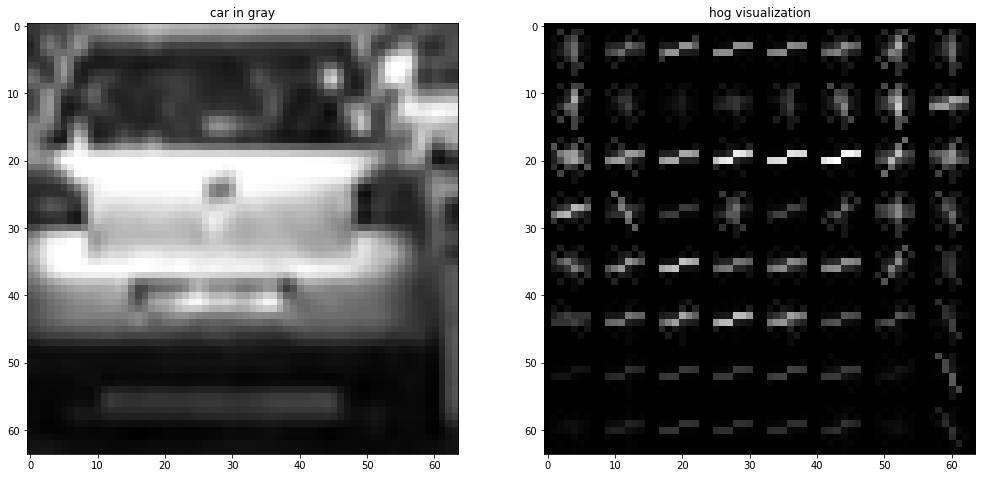

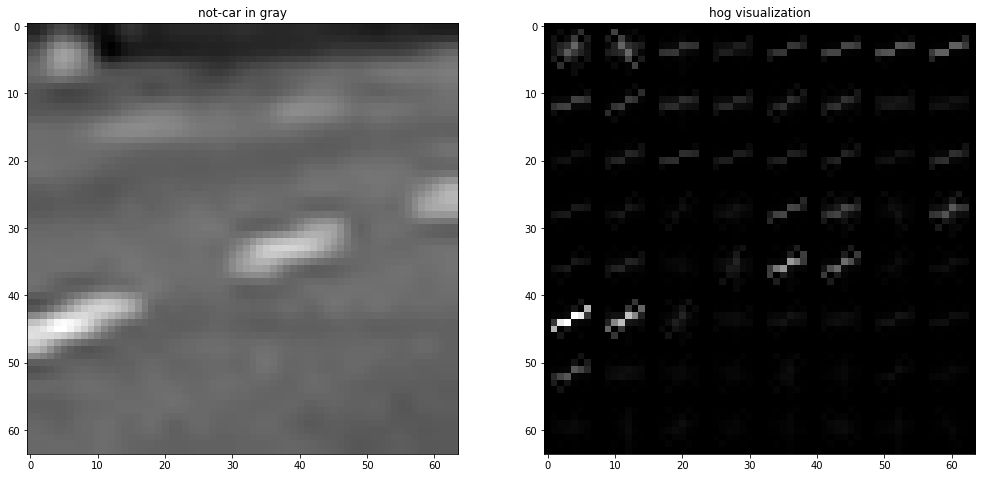

In [6]:
# exploration hog
_fn1 = "vehicles/GTI_MiddleClose/image0100.png"
_fn2 = "non-vehicles/GTI/image205.png"

_im_rgb = mpimg.imread(_fn1)
_im_gray = cv2.cvtColor(_im_rgb,cv2.COLOR_RGB2GRAY)
_features, _hog_image = get_hog_feature(_im_gray, HOG_BINS, PIX_P_CELL, CELL_P_BLOCK, True, False)
plot_2_images(_im_gray, _hog_image, "car in gray", "hog visualization")

_im_rgb = mpimg.imread(_fn2)
_im_gray = cv2.cvtColor(_im_rgb,cv2.COLOR_RGB2GRAY)
_features, _hog_image = get_hog_feature(_im_gray, HOG_BINS, PIX_P_CELL, CELL_P_BLOCK, True, False)
plot_2_images(_im_gray, _hog_image, "not-car in gray", "hog visualization")

In [7]:
# train calssifier

t=time()
# (1) get data
X, Y = get_X_Y(_paths,_are_labels,CSPACE,CHANNEL)

# (2) feature extraction & normalize
F    = get_F(X, HOG_BINS, PIX_P_CELL,CELL_P_BLOCK,HIS_BINS)
print('features extracted')
print('shape of F = {}'.format(F.shape))

# (3) normalize
F_scaler = StandardScaler()
F_scaler.fit(F)
F_n = F_scaler.transform(F)
print('normalized')

# (4) shuffle and partition
F_n, Y = shuffle(F_n,Y)
X_train, X_test, Y_train,Y_test  = train_test_split(F_n,Y,test_size=TEST_FRAC)
print('partitioned')

# (5) train using a linear SVC 
svc = LinearSVC(C=C_SVM)
print(X_train.shape)
svc.fit(X_train, Y_train)
t2 = time()
print(round(t2-t, 2), 'Seconds to train classifier...')
# Check the score of the SVC
print('Train data accuracy of SVC = ', round(svc.score(X_train, Y_train), 4))
print('Test  data accuracy of SVC = ', round(svc.score(X_test, Y_test), 4))
# Check the prediction time for a single sample

directories included:
   vehicles/GTI_MiddleClose/*.png, with 419 images
   vehicles/GTI_Right/*.png      , with 664 images
   vehicles/GTI_Left/*.png       , with 909 images
   vehicles/GTI_Far/*.png        , with 834 images
   vehicles/KITTI_extracted/*.png, with 5966 images
   non-vehicles/mine/*.png       , with 7 images
   non-vehicles/Extras/*.png     , with 5068 images
   non-vehicles/GTI/*.png        , with 3900 images
shape of X = (17767, 64, 64, 3)
ratio of cars to total images = 8792/17767=0.49
features extracted
shape of F = (17767, 1824)
normalized
partitioned
(13325, 1824)
41.31 Seconds to train classifier...
Train data accuracy of SVC =  0.9985
Test  data accuracy of SVC =  0.9885


## Explore Detection ##

Found 6 images: test6.jpg , test4.jpg , test1.jpg , test2.jpg , test5.jpg , test3.jpg , 

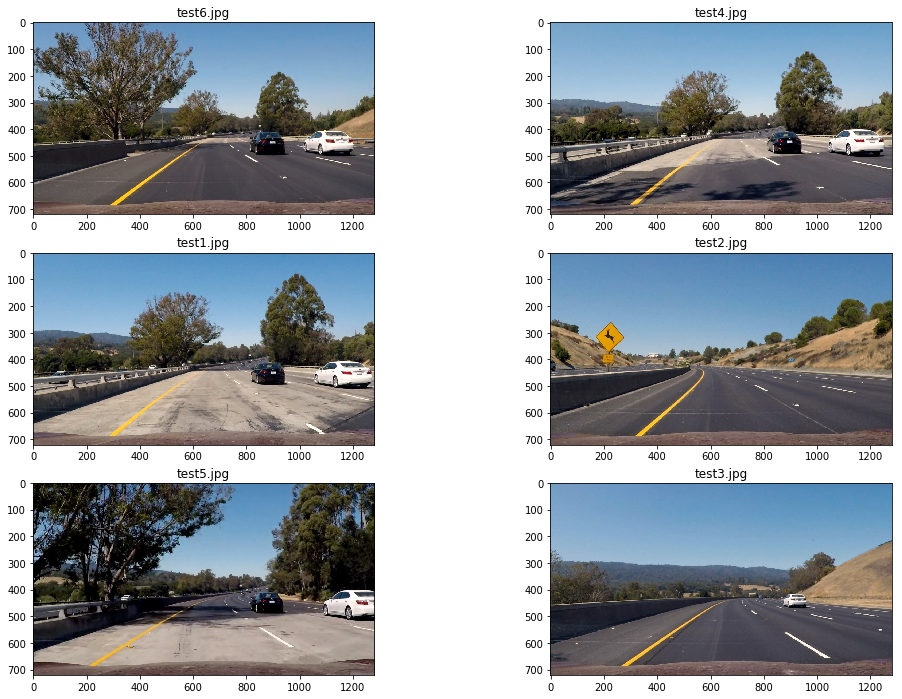

In [8]:
# read and plot test images
_path = "test_images/*.jpg"
images_rgb, images_gry, names = get_images(_path)
plot_images(images_rgb,names)

scaled image shape = (74, 544)
hog shape          = (2, 61, 8, 8, 9)
scaled image shape = (78, 832)
hog shape          = (2, 97, 8, 8, 9)
scaled image shape = (83, 800)
hog shape          = (3, 93, 8, 8, 9)
boxes              = 174


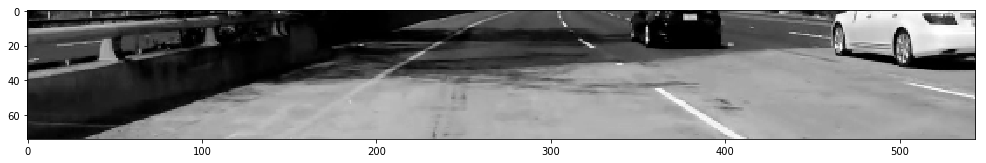

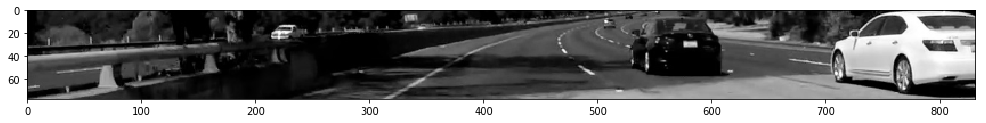

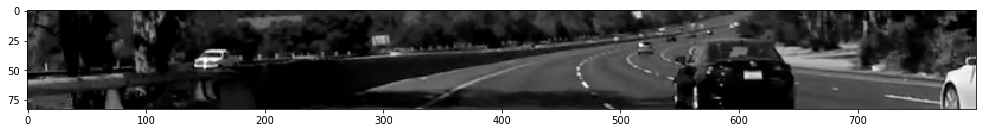

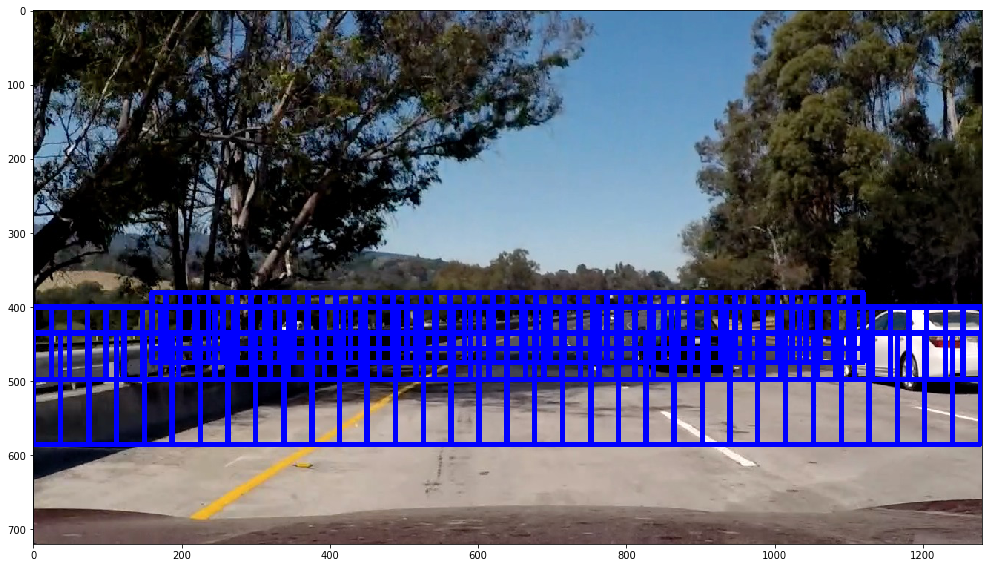

In [9]:
# explore windows
i = 4
_im = images_rgb[i,:,:,:]
#_im = mpimg.imread(im_out)
_boxes = explore_boxes(_im, Y_LIM, X_LIM, SCALE, INT_X, INT_Y, HOG_BINS, PIX_P_CELL,CELL_P_BLOCK,CSPACE)
print('boxes              =',len(_boxes))
_image = draw_boxes(_im, _boxes, color=(0, 0, 255), thick=6)
plt.figure(figsize=(17,14))
plt.imshow(_image);

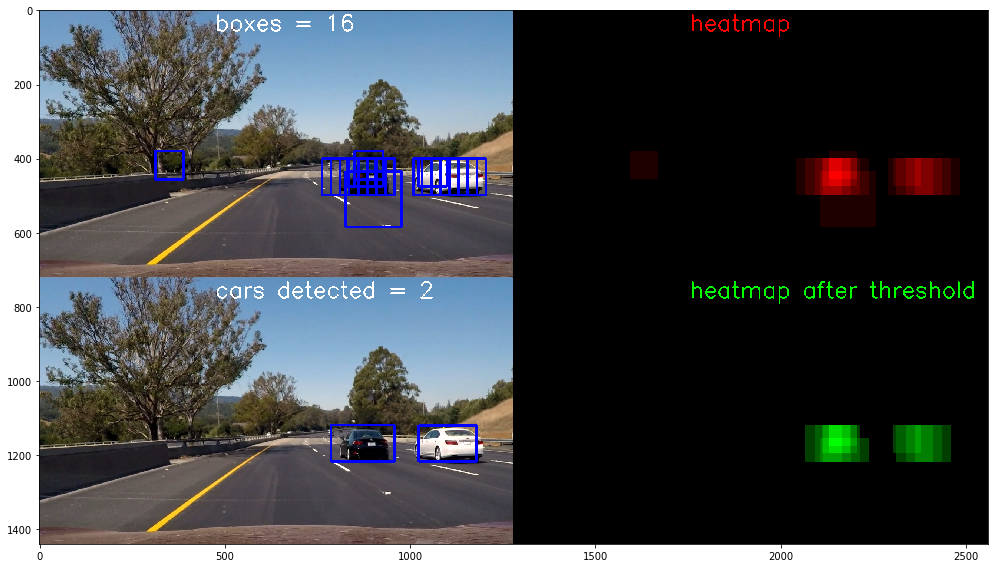

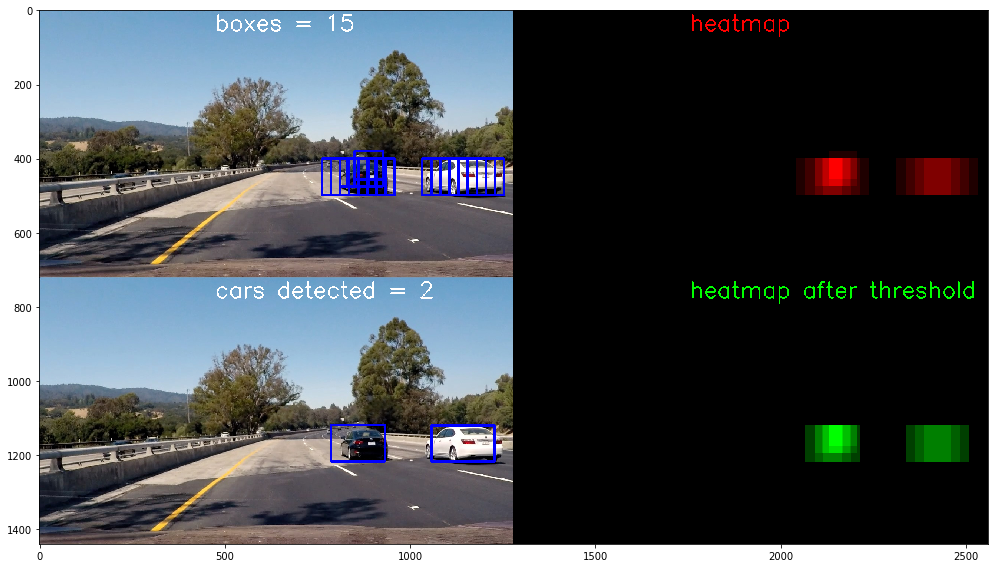

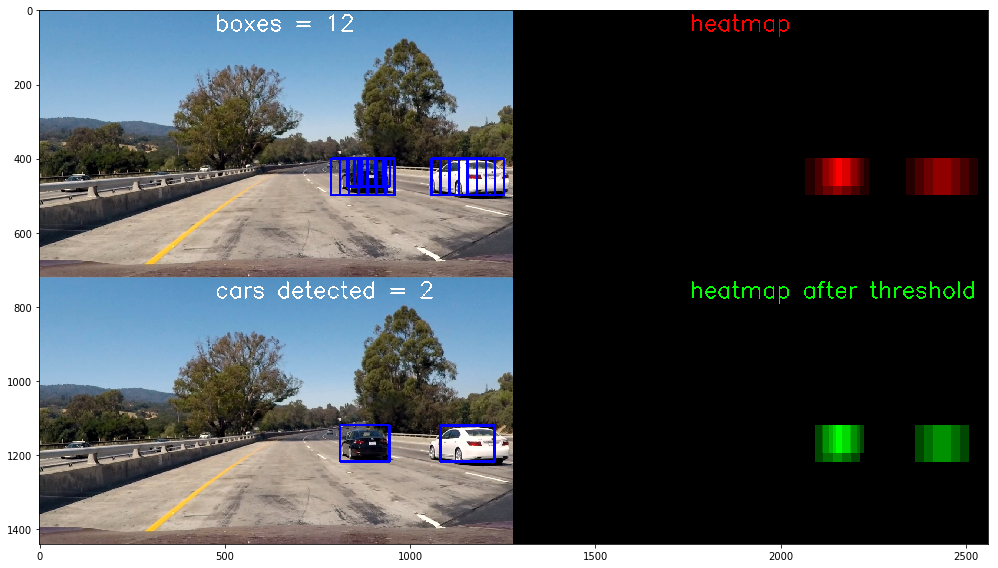

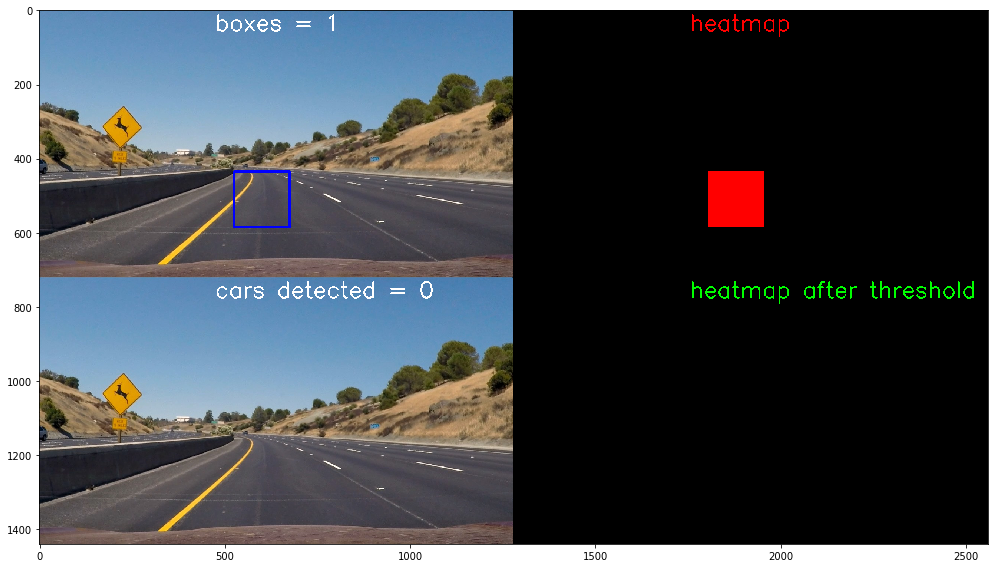

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


In [10]:
# Explore detection on test images
FRAMES         = 1
HEAT_THR       = 1

heat_state = state(FRAMES,(720,1280))

for i in range(6):
    _im = images_rgb[i,:,:,:]
    _im_out = pipe_debug(_im) 
    plt.figure(figsize=(17,14))
    plt.imshow(_im_out)

In [11]:
video_in     = 'project_video.mp4'
video_out    = 'P5_video_debug.mp4'

FRAMES         = 16         # frames to average for heatmap
HEAT_THR       = 27          # threshold for accumulated heatmap
# initialize class
heat_state = state(FRAMES,(720,1280))

# read video into clip_in
clip_in = VideoFileClip(video_in) 

# transform frames
clip_out = clip_in.fl_image(pipe_debug)

# store
%time clip_out.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video P5_video_debug.mp4
[MoviePy] Writing video P5_video_debug.mp4


100%|█████████▉| 1260/1261 [04:29<00:00,  5.14it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_video_debug.mp4 

CPU times: user 6min 57s, sys: 5.04 s, total: 7min 2s
Wall time: 4min 30s


In [12]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))

In [13]:
# MAIN VIDEO generator
video_in     = 'project_video.mp4'
video_out    = 'P5_video.mp4'

heat_state = state(FRAMES,(720,1280))
clip_in = VideoFileClip(video_in) 
clip_out = clip_in.fl_image(pipe)
%time clip_out.write_videofile(video_out, audio=False)

[MoviePy] >>>> Building video P5_video.mp4
[MoviePy] Writing video P5_video.mp4


100%|█████████▉| 1260/1261 [04:15<00:00,  4.62it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: P5_video.mp4 

CPU times: user 7min 2s, sys: 6.23 s, total: 7min 8s
Wall time: 4min 16s


In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_out))